In [1]:
#This notebook will tile up imagey so that each tiles matches the pixel size and locations of a raster dataset, 
#this is usefull when you are combining image clasification with other raster raster datasets

In [ ]:
import os
import subprocess
import math
from pathlib import Path
from tqdm.auto import tqdm
from multiprocessing import Pool

from osgeo import gdal
import geopandas as gpd
import pandas as pd

import numpy as np
from shapely import geometry

In [2]:
raster_to_match = '/media/nick/4TB Working/Dataset/South west 90m vivid/relief_dems_3s_mosaic1_clip_to_sw.tif'

In [3]:
output_folder = '/media/nick/4TB Working/Dataset/South west 90m vivid/90m sw tiles'

geotiff_folder = '/media/nick/4TB Working/Dataset/South west 90m vivid/Vivid tiles within'
    
input_file_ext = '.tif'
output_compression = 'JPEG'

In [ ]:
#if you want your images to be some multible of the raster pixel size use this option,
#otherwise set this to 1
downsample_raster_factor = 3

In [4]:
# open raster to match and extract extent and pixel size
data = gdal.Open(raster_to_match)
geoTransform = data.GetGeoTransform()
bound_x_min = geoTransform[0]
bound_y_max = geoTransform[3]
bound_x_max = bound_x_min + geoTransform[1] * data.RasterXSize
bound_y_min = bound_y_max + geoTransform[5] * data.RasterYSize

x_count = data.RasterXSize
y_count = data.RasterYSize
x_move = geoTransform[1]
y_move = geoTransform[5]

x_move = x_move*downsample_raster_factor
y_move = y_move*downsample_raster_factor

In [6]:
# search folder and all sub folders for 'input_file_ext' files
geo_tiff_list = []
for root, dirs, files in os.walk(geotiff_folder):
    for file in files:
        if file.endswith(input_file_ext):
            geo_tiff_list.append(os.path.join(root, file))
            
print('We found ',len(geo_tiff_list),input_file_ext,'files')

We found  3446 .tif files


In [7]:
# if you want to filter our input raster use this
# polygons = gpd.read_file('/media/nick/2TB Working 2/Image sets/VIVID South West polygons.gpkg')
# polygons = gpd.read_file('/mnt/2TB Working 2/Projects/Nulla ML test/image classification/full preds/vivid tiles within.gpkg')

# polygons

In [8]:
# valid_names = set(polygons.tile.tolist())
# short_list = []
# for tif in geo_tiff_list:
#     file_name = os.path.basename(tif).replace('.tif','')
    
#     if file_name in valid_names:
#         short_list.append(tif)
        
# geo_tiff_list = short_list
# len(geo_tiff_list)    

In [9]:
def get_bounds(tif_path):
#     open file
    data = gdal.Open(tif_path)
#     grab bounds
    geoTransform = data.GetGeoTransform()
    left = geoTransform[0]
    top = geoTransform[3]
    right = left + geoTransform[1] * data.RasterXSize
    bottom = top + geoTransform[5] * data.RasterYSize
    geo_tiff_bounds_dict = {'top':top,'left':left,'bottom':bottom,'right':right,'tif_path':tif_path}
    return geo_tiff_bounds_dict

In [10]:
geo_tiff_bounds = get_bounds(geo_tiff_list[0])
geo_tiff_bounds

{'top': -33.3984375,
 'left': 117.333984375,
 'bottom': -33.486328125,
 'right': 117.421875,
 'tif_path': '/media/nick/4TB Working/Dataset/South west 90m vivid/Vivid tiles within/VIVID_Landgate_20190910_112120110133.tif'}

In [11]:
# use multiprocessing to extract raster bounds
with Pool() as pool:
    geo_tiff_bounds = list(tqdm(pool.imap(get_bounds, geo_tiff_list), total=len(geo_tiff_list)))


  0%|          | 0/3446 [00:00<?, ?it/s]

In [16]:
# calculate the number of cols so we can avoid using while loops
number_of_cols = math.ceil(abs((bound_x_max-bound_x_min)/x_move))
number_of_cols

3664

In [17]:
# calculate the number of rows so we can avoid using while loops
number_of_rows = math.ceil(abs((bound_y_max-bound_y_min)/y_move))
number_of_rows

3052

In [18]:
number_of_rows*number_of_cols

11182528

In [19]:
# will return a list of geotiffs which intersect 
def intersect_tile_with_geotiffs(tile_dict,geo_tiff_bounds):
#     loop over each geotiff
    intersecting_geotiffs = set()
    
    for geo_bounds in geo_tiff_bounds:
#         check is tile top or bottom is inside geotiff
        if (geo_bounds['top'] > tile_dict['top'] > geo_bounds['bottom'] or 
            geo_bounds['top'] > tile_dict['bottom'] > geo_bounds['bottom']):
#         check if left or right are inside a geotiff
            if geo_bounds['right'] > tile_dict['left'] > geo_bounds['left']:
                intersecting_geotiffs.add(geo_bounds['tif_path'])
            if geo_bounds['right'] > tile_dict['right'] > geo_bounds['left']:
                intersecting_geotiffs.add(geo_bounds['tif_path'])
    return intersecting_geotiffs

In [20]:
# will take tile bounds and only export them if they fall within a geotiff
# this is called row by row by pool below
def make_polygons(row):
    tile_polygon_list = []
    tile_top = bound_y_max + y_move*row
    tile_bottom = tile_top + y_move
    tile_left = bound_x_min

    for col in range(0,number_of_cols):
        tile_left = bound_x_min + col*x_move
        tile_right = tile_left + x_move
        tile_dict = {'top':tile_top,'left':tile_left,'bottom':tile_bottom,'right':tile_right}
        tile_list = np.array([tile_top,tile_left,tile_bottom,tile_right])
#         check if valid tile
        intersect = intersect_tile_with_geotiffs(tile_dict,geo_tiff_bounds)
        raster_name = str(row)+'_'+str(col)+'.tif'
        if len(intersect) > 0:
            polygon = {'geometry':geometry.Polygon([[tile_left, tile_top], [tile_right, tile_top], [tile_right, tile_bottom], [tile_left, tile_bottom]]),
                      'intersect':intersect, 'row':row, 'col':col, 'name':raster_name}
            tile_polygon_list.append(polygon)
    return tile_polygon_list


In [21]:
# %%time
# tile_polygon_list = []
# for row in tqdm(range(0,number_of_rows)):
#     tile_polygon_list.append(make_polygons(row))
#     break

In [22]:
# tile_polygon_list[0][0]['geometry']

In [23]:
%%time
# multiprocess making polygons
with Pool() as pool:
#     tile_polygon_list = pool.map(make_polygons, range(0,number_of_rows))
    tile_polygon_list = list(tqdm(pool.imap(make_polygons, range(0,number_of_rows)), total=len(range(0,number_of_rows))))

# this is returned as a list of list so it must be flattened
tile_polygon_list = list(np.concatenate(tile_polygon_list).ravel())
print(len(tile_polygon_list))

  0%|          | 0/3052 [00:00<?, ?it/s]

4263819
CPU times: user 59 s, sys: 7.34 s, total: 1min 6s
Wall time: 4min 30s


In [24]:
%%time
#  convert into geodataframe
polygon_tiles_gpd = gpd.GeoDataFrame(tile_polygon_list,geometry='geometry',crs='EPSG:4326')
del polygon_tiles_gpd['intersect']

CPU times: user 7.72 s, sys: 144 ms, total: 7.87 s
Wall time: 7.87 s


<AxesSubplot:>

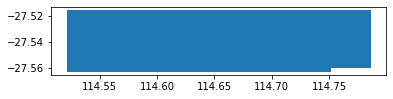

In [25]:
polygon_tiles_gpd.head(2000).plot()

In [26]:
# polygon_tiles_gpd.head(2).to_file(os.path.join(output_folder,'output.gpkg'), driver="GPKG")    

In [27]:
polygon_tiles_gpd.to_file(os.path.join(output_folder,'output.gpkg'), driver="GPKG")    

In [28]:
tile_polygon_list[1]

{'geometry': <shapely.geometry.polygon.Polygon at 0x7fcf0964fb80>,
 'intersect': {'/media/nick/4TB Working/Dataset/South west 90m vivid/Vivid tiles within/VIVID_Landgate_20190910_112122010331.tif'},
 'row': 0,
 'col': 170}

In [29]:
# make a list of which tiles are within which geotiffs
# loop over each geotiff
# for geo_tiff in tqdm(geo_tiff_list):
def intersector(geo_tiff):
    tiles_inside_geo_tiff = []
#     loop over each tile and check if the geotiff is the the intersect list
    for tile in tile_polygon_list:
        if geo_tiff in tile['intersect']:
#             we count this so we know if the tile will be incomplete or not
            incomplete = len(tile['intersect'])>1
#             build dict with geom the current row and col for naming
            tiles_inside_geo_tiff.append({'geometry':tile['geometry'],'row':tile['row'],'col':tile['col'],'incomplete':incomplete})
    return([geo_tiff,tiles_inside_geo_tiff])  

In [31]:
with Pool() as pool:
    geo_tiff_with_tiles = list(tqdm(pool.imap(intersector, geo_tiff_list), total=len(geo_tiff_list)))


In [32]:
# loop over each geotiff
# for geotiff in tqdm(geo_tiff_with_tiles):
def cut_tiles(geotiff):
#     grab path to to file and open it
    geotiff_open = gdal.Open(geotiff[0])
#     grab the filename and strip the extention
    geo_tiff_filename = os.path.basename(geotiff[0]).replace(input_file_ext,'')
    incomplete_tile_list = []
    for tile in geotiff[1]:
        time_geometry = tile['geometry']
#         shapely bounds returns "minx, miny, maxx, maxy" but we need minx, maxy, maxx, miny
        top = list(time_geometry.bounds)[3]
        bottom = list(time_geometry.bounds)[1]
        left = list(time_geometry.bounds)[0]
        right =list(time_geometry.bounds)[2]
        
#         make row folder path
        output_row_folder = os.path.join(output_folder,str(tile['row']))
#       make row folder if nessasary
        Path(output_row_folder).mkdir(parents=True, exist_ok=True)
        export_file_name = str(tile['row'])+'_'+str(tile['col'])+'.tif'
        
#         check if tile is incomplete if so append the getiff name so that it is unique
        if tile['incomplete']:
            append_name = '-'+geo_tiff_filename+'_incomplete.tif'
            export_file_name = export_file_name.replace('.tif',append_name)
#             add tile to list so we dont need to refind them to compile incomplete tiles
            export_file_path = os.path.join(output_row_folder,export_file_name)
            incomplete_tile_list.append(export_file_path)
        else:
            export_file_path = os.path.join(output_row_folder,export_file_name)
        
#         check if already done
        if not os.path.isfile(export_file_path):

    #     clip the data
    #         make a string of tile dims to pass as a command line arg, this is ugly, would like a better option
            tile_clip_string = str(left) +' '+str(top) +' '+str(right) +' '+str(bottom)

            translate_options = gdal.TranslateOptions(gdal.ParseCommandLine("-projwin "+tile_clip_string)
                                                     ,creationOptions=['COMPRESS='+output_compression])

            tile_clip = gdal.Translate(export_file_path, geotiff_open, options = translate_options)
    #     close the tile
            tile_clip = None
    #         break
    return incomplete_tile_list

    

In [33]:
pool = Pool()
with pool:
    incomplete_tile_list = list(tqdm(pool.imap(cut_tiles,geo_tiff_with_tiles), total=len(geo_tiff_with_tiles)))

In [34]:
#  the pool above returns all the incomplete tiles as a list of list, we need a flat list
flat_incomplete_tile_list = [item for sublist in incomplete_tile_list for item in sublist]
print(len(flat_incomplete_tile_list),'incomplete tiles')

In [35]:
incomplete_tile_file_names = []
# from the flat list make a new list with just rows and cols to filter by
for incomplete_tile in flat_incomplete_tile_list:
    incomplete_tile_file_names.append(os.path.basename(incomplete_tile).split('-')[0])

In [36]:
# make a new datframe with paths and row/cols
incomplete_tile_df = pd.DataFrame(
    {'incomplete_tiles': flat_incomplete_tile_list,
     'row_col': incomplete_tile_file_names
    })

In [37]:
# handy gdal tool to merge files
def merge_tiles(merge_imgs, output_path):
    merge_command = ['gdal_merge.py', '-o', output_path, '-co','COMPRESS='+output_compression]
    for name in merge_imgs:
        merge_command.append(name)
    subprocess.run(merge_command)

In [38]:
def join_incomplete_tile(unique_tiles):
# for unique_tiles in incomplete_tile_df.row_col.unique():
#     filter the datframe down to only onw row and col
    gapminder_2002 = incomplete_tile_df[incomplete_tile_df['row_col']==unique_tiles]
#     get paths as list
    combine_these = gapminder_2002['incomplete_tiles'].tolist()
#     get export name by removing the geotiff names from end
    export_file_name = os.path.basename(combine_these[0]).split('-')[0]+'.tif'
#     grab the folder from the first tile
    export_dir_path = os.path.dirname(combine_these[0])
#     biuld full export path
    export_full_path = os.path.join(export_dir_path,export_file_name)
#     use gdal gdal_merge.py to merge the tiles
    merge_tiles(combine_these,export_full_path)
#     remove the incomplete tiles and msk files
    for incomplete_tile in combine_these:
        try:
            os.remove(incomplete_tile)
        except:
            print('could not remove')
        try:
            os.remove(incomplete_tile+'.msk')
        except:
            print('could not remove')
#     break
    

In [39]:
unique_tiles_list = incomplete_tile_df.row_col.unique()
pool = Pool()
with pool:
    incomplete_tile_list = list(tqdm(pool.imap(join_incomplete_tile,unique_tiles_list), total=len(unique_tiles_list)))